In [37]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节
code = "sh.600183"
rs = bs.query_history_k_data_plus(code,
    "time,open,high,low,close,volume,amount",
    start_date='2020-01-01', end_date='2030-12-31', 
    frequency="5", adjustflag="2") #frequency="d"取日k线，adjustflag="2" #复权类型:1-后复权，2-前复权，3-不复权
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### join result ####
data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### logout system ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
logout success!


In [38]:
for col in rs.fields:
    if col == 'time':
        result[col] = pd.to_datetime(result[col],format='%Y%m%d%H%M%S%f')
    else:
        result[col] = pd.to_numeric(result[col])
result.index = result['time']
result.index.name = 'time_index'

In [39]:
result.describe()

,time,open,high,low,close,volume,amount
count,65760,65760.000000,65760.000000,65760.000000,65760.000000,6.576000e+04,6.576000e+04
mean,2022-10-31 21:59:48.394160640,20.184677,20.228683,20.141760,20.185263,5.455785e+05,1.316571e+07
min,2020-01-02 09:35:00,11.754377,11.782209,11.726545,11.754377,0.000000e+00,0.000000e+00
25%,2021-06-03 12:41:15,15.530152,15.559131,15.493141,15.530250,2.089000e+05,3.927299e+06
50%,2022-11-02 00:17:30,19.949827,19.987622,19.914673,19.949827,3.630000e+05,7.704226e+06
75%,2024-03-29 11:53:45,23.263480,23.324599,23.210011,23.263080,6.436170e+05,1.534224e+07
max,2025-08-26 15:00:00,49.980000,50.500000,49.860000,50.030000,3.221398e+07,8.462223e+08
std,NaN,5.554470,5.575652,5.534422,5.555650,6.744172e+05,1.918942e+07


In [40]:
class Trading_Simulator:
    def __init__(self, initial_cash=30000.0):
        self.current_cash = initial_cash
        self.current_share = 0.0
        self.freze_share = 0.0
        self.commission = 1.1/1e5
        self.tax = 5/1e5
        self.history = []

    def buy(self, price, number=100):
        if self.current_cash < price*number*(1+self.commission):
            # print("Error: Not enough cash to buy")
            number = int(self.current_cash / (price*(1+self.commission)) / 100) * 100
        self.current_cash -= price*number*(1+self.commission)
        self.freze_share += number
        history_entry = {'price': price, 'number': number}
        self.history.append(history_entry)

    def sell(self, price, number=100):
        if number > self.current_share:
            # print("Error: Not enough shares to sell")
            number = self.current_share
        self.current_cash += price*number*(1-self.commission-self.tax)
        self.current_share -= number
        history_entry = {'price': price, 'sell_number': -number}
        self.history.append(history_entry)

    def settle(self):
        self.current_share += self.freze_share
        self.freze_share = 0.0

class Recorder:
    def __init__(self):
        self.max_value = -float('inf')
        self.min_value = float('inf')
        self.values = []

    def reset(self):
        self.max_value = -float('inf')
        self.min_value = float('inf')
        self.values = []

    def record(self, value):
        self.values.append(value)
        if value > self.max_value:
            self.max_value = value
        if value < self.min_value:
            self.min_value = value

    def __call__(self, value):
        return self.record(value)


In [41]:
ts = Trading_Simulator(3e4)
rec = Recorder()
current_date = None
alls = []
for index, row in result.iterrows():
    bs_prices = []
    if current_date != row['time'].date():
        alls.append([current_date, ts.current_cash+(ts.current_share+ts.freze_share)*rec.values[-1] if rec.values else 0])
        current_date = row['time'].date()
        # New trading day, settle previous trades
        ts.settle()
        rec.reset()
        # print("#"*20)
        # print(f"Date: {current_date}, Cash: {ts.current_cash}, Shares: {ts.current_share}")
        rec(row['open'])
    rec(row['close'])
    if (row['close'] > rec.min_value * 1.01) and (row['close'] <= min(bs_prices) if bs_prices else float('inf')):
        # print(f"Buy at {row['close']}")
        number_to_buy = int((row['close'] - rec.min_value)/rec.min_value*100) * 100
        ts.buy(row['close'])
        bs_prices.append(row['close'])
    elif (row['close'] < rec.max_value * 0.99) and (row['close'] >= max(bs_prices) if bs_prices else -float('inf')):
        # print(f"Sell at {row['close']}")
        number_to_sell = int((rec.max_value - row['close'])/rec.max_value*100) * 100
        ts.sell(row['close'], number_to_sell)
        bs_prices.append(row['close'])
trade_df = pd.DataFrame(alls, columns=['date', 'total_value'])
trade_df.dropna(inplace=True)

print(f"Date: {current_date}, Cash: {ts.current_cash}, Shares: {ts.current_share+ts.freze_share}")
print(alls[-1])

Date: 2025-08-26, Cash: 91738.74688185507, Shares: 0.0
[datetime.date(2025, 8, 25), 93404.12134785506]


In [42]:
import short_signal_module as ssm
bdf = ssm.apply_t1_exits(ssm.generate_signals(result), capital=300, risk_fraction=0.005)
perf, trades = ssm.evaluate_performance(bdf, 300)
print(perf)

d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根


{'max_drawdown': -0.18449351810814785, 'sharpe': 1.0475226096880312, 'total_return': 1.0763684091597359, 'num_trades': 438, 'win_rate': 0.4908675799086758, 'avg_win': 5.8437729794500335, 'avg_loss': -4.186101649479087}


In [43]:
bdf

,time,open,high,low,close,volume,amount,EMA5,EMA20,RSI,...,atr_pct,signal,position,entry_price,exit_price,shares,pnl,holding_days,equity,trade_pnl
time_index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:35:00,2020-01-02 09:35:00,18.515957,18.541938,18.264805,18.273465,4635300,98585861.0,18.273465,18.273465,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:40:00,2020-01-02 09:40:00,18.264805,18.429352,18.212842,18.386050,2183878,46229939.0,18.310994,18.284188,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:45:00,2020-01-02 09:45:00,18.403371,18.455334,18.368730,18.386050,2074560,44118640.0,18.336013,18.293889,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:50:00,2020-01-02 09:50:00,18.377390,18.576579,18.377390,18.567919,3660608,78201338.0,18.413315,18.319987,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:55:00,2020-01-02 09:55:00,18.559259,18.767108,18.550598,18.758448,4648233,100050318.0,18.528359,18.361745,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-26 14:40:00,2025-08-26 14:40:00,48.470000,48.480000,48.350000,48.350000,374700,18131584.0,48.382346,48.478236,39.130435,...,0.002408,0,0,NaN,NaN,0,0.0,0,622.910523,0.0
2025-08-26 14:45:00,2025-08-26 14:45:00,48.350000,48.370000,48.290000,48.300000,589500,28483712.0,48.354897,48.461261,41.538462,...,0.002381,0,0,NaN,NaN,0,0.0,0,622.910523,0.0
2025-08-26 14:50:00,2025-08-26 14:50:00,48.290000,48.310000,48.130000,48.130000,998100,48159872.0,48.279932,48.429713,29.487179,...,0.002538,0,0,NaN,NaN,0,0.0,0,622.910523,0.0


In [44]:
bdf['_equity'] = bdf['equity']*100

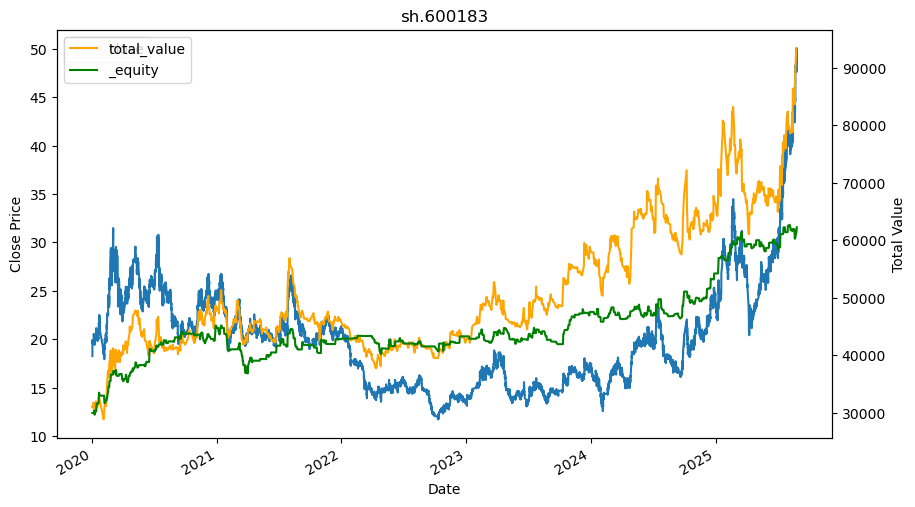

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
twin_ax = ax.twinx()
result.plot(x='time', y='close', title=code, xlabel='Date', ylabel='Close Price', ax=ax)
trade_df.plot(x='date', y='total_value', ylabel='Total Value', ax=twin_ax, color='orange', sharex=True)
bdf.plot(x='time', y='_equity', ax=twin_ax, color='green', sharex=True)
plt.show()

In [46]:
ssm.grid_search(result)

d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根
d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根
d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beha

,vol_multiplier,donchian_n,trail_init,trail_atr,max_drawdown,sharpe,total_return,num_trades,win_rate,avg_win,avg_loss
0,1.3,15,1.5,1.0,-0.141865,1.268049,1.396908,524,0.479008,2019.019127,-1344.626538
3,1.3,15,2.0,1.0,-0.141865,1.268049,1.396908,524,0.479008,2019.019127,-1344.626538
6,1.3,15,2.5,1.0,-0.141865,1.268049,1.396908,524,0.479008,2019.019127,-1344.626538
1,1.3,15,1.5,1.5,-0.141967,1.266850,1.395680,524,0.479008,2018.529896,-1344.626538
4,1.3,15,2.0,1.5,-0.141967,1.266850,1.395680,524,0.479008,2018.529896,-1344.626538
...,...,...,...,...,...,...,...,...,...,...,...
74,1.8,30,1.5,2.0,-0.160449,0.873637,0.806858,320,0.503125,2025.185325,-1543.201239
76,1.8,30,2.0,1.5,-0.160449,0.873637,0.806858,320,0.503125,2025.185325,-1543.201239
77,1.8,30,2.0,2.0,-0.160449,0.873637,0.806858,320,0.503125,2025.185325,-1543.201239
79,1.8,30,2.5,1.5,-0.160449,0.873637,0.806858,320,0.503125,2025.185325,-1543.201239
